# Pokemon Identifier

This is going to train a pokemon identifier that will be trained on several data sources

In [1]:
import os
import sys
import string
import datetime
import shutil
import argparse
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.preprocessing.image as preprocessing 
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from imutils import paths #used to get the paths of all images in a dir

In [2]:
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nzf_z6e1 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Global Values

In [3]:
clearLogs = False
strNow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ENV = "ubuntuLocal"

#path to dataset directory
ENV_LOG_DIR = f"../Logs/{ENV}/"
SESSION_LOG_DIR = f"../Logs/{ENV}/{strNow}/"
CORE_DATASET = '../Datasets/Main/Images/'
# SAVE_DIR = os.path.join(SESSION_LOG_DIR, "Saves")
# CHECKPOINT_DIR = os.path.join(SAVE_DIR, "Checkpoints")
# FINAL_SAVE_DIR = os.path.join(SAVE_DIR, "Final")
if os.path.isdir('../Logs') is False:
    os.mkdir('../Logs')
if os.path.isdir(ENV_LOG_DIR) is False:
    os.mkdir(ENV_LOG_DIR)
if os.path.isdir(SESSION_LOG_DIR) is False: 
    os.mkdir(SESSION_LOG_DIR)

numCategories = len(os.listdir(CORE_DATASET))

#amount of time to allot for training
trainTimeLimit = 0

#percentage of core dataset to use for training and testing
TRAIN_SPLIT = .9 

if clearLogs is True and os.path.isdir('../Logs') :
    shutil.rmtree('../Logs')
    
if os.path.isdir(CORE_DATASET) is False:
    print('DATASET NOT FOUND') 

BATCH_SIZE = 255

NUM_EPOCHS = 7

IMAGE_HEIGHT = 80
IMAGE_WIDTH = 80
#normalization value that will be used for color channels
IMAGE_NORM_COLOR = 255 

### Data Pipeline Params

In [4]:
PIPE_USE_RAND_ZOOM = True
PIPE_RAND_ZOOM_AMT = (-0.05, 0.05)
PIPE_USE_CACHE = False
PIPE_RATIO_TRAIN = 0.90
PIPE_RATIO_VALID = 1 - PIPE_RATIO_TRAIN

### Training Params

In [5]:
NUM_NODES_IN_CONV = [128]
NUM_LAYERS_CONV = [4]
CONV_KERNEL_SIZE = [(3,3)]
REGULARIZER_LEARNING_RATE = [0.01]
USE_BATCH_NORMS = [True]
DROPOUT_RATE = [0.4]    #use same number of elements in list for all dropout args
DROPOUT_RATE_HIDDEN = [0.5]
SPATIAL_DROPOUT_USE = False
SPATIAL_DROPOUT_RATE = 0.5

### Take command line arguments if any

In [6]:
if (len(sys.argv) > 0):
    print(sys.argv)
    listArgs = sys.argv
    for arg in listArgs: 
        splitArg = arg.split('=')
        if splitArg[0] == "timeLimit": 
            timeSplit = splitArg[1].split('.')
            if (len(timeSplit) == 3):
                hours = int(timeSplit[0])
                minutes = int(timeSplit[1])
                seconds = int(timeSplit[2])
                trainTimeLimit = (60*60*hours)+(60*minutes)+seconds
                print(f'time limit set to- {trainTimeLimit} seconds') 
        elif splitArg[0] == "epochs":
            numEpochs = int(splitArg[1])
        elif splitArg[0] == "cache":
            PIPE_USE_CACHE = bool(splitArg[1])
            print('Will utilize caching for dataset')
        elif splitArg[0] == "batchNorm":
            USE_BATCH_NORMS = bool(splitArg[1])

['/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py', '-f', '/.local/share/jupyter/runtime/kernel-11e2285c-689e-4506-b12f-4a98b4a64d08.json']


## Train

### Create Datasets with TF.Data

In [7]:


# #generate training and testing split 
# i = int(len(imagePaths) * 

# datasets = [
#     ("training", trainPaths, TRAIN_DIR),
#     ("validation", validationPaths, VALIDATION_DIR)
# ]

In [8]:
def loadImages(imagePath):
    #encode the image
    # tf.print(imagePath)
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize_with_pad(image, IMAGE_HEIGHT, IMAGE_WIDTH)
    image = tf.cast(image, tf.float32)
    
    #encode the label for the image
    labelParts = tf.strings.split(imagePath, os.sep)
    oneHot = labelParts[-2] == classNames 
    return (image, tf.argmax(oneHot))

In [9]:
seqAugment = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/255),
    tf.keras.layers.RandomZoom(
        height_factor=PIPE_RAND_ZOOM_AMT, #zoom in by random ammount from +20% to +30%
        width_factor=PIPE_RAND_ZOOM_AMT, 
        fill_mode='constant', 
        fill_value=0)
])

In [10]:
imagePaths = list(paths.list_images(CORE_DATASET))
random.seed(32)
random.shuffle(imagePaths)
trainLabels = [p.split(os.path.sep)[-2] for p in imagePaths] #gather labels from dirs 
classNames = np.array(sorted(trainLabels))
classNames = np.unique(classNames)
print(len(imagePaths))

numTrain = int(len(imagePaths) * PIPE_RATIO_TRAIN)
numVal = int(len(imagePaths) * PIPE_RATIO_VALID)

#define pipelines 
#training dataset 
trainDS = tf.data.Dataset.from_tensor_slices(imagePaths[:numTrain])
trainDS = (trainDS
           .shuffle(len(imagePaths)) #shuffle all the images 
           .map(loadImages, num_parallel_calls=AUTOTUNE) #read images from disk 
           .apply(tf.data.experimental.ignore_errors())
           .map(lambda x, y: (seqAugment(x), y), num_parallel_calls=AUTOTUNE)
        )

if PIPE_USE_CACHE is True: 
    trainDS = trainDS.cache()
trainDS = (trainDS
           .batch(BATCH_SIZE) #batch size
           .prefetch(AUTOTUNE)
          )

#validation dataset
valDS = tf.data.Dataset.from_tensor_slices(imagePaths[numTrain :])
valDS = (valDS
         .map(loadImages, num_parallel_calls=AUTOTUNE)
         .apply(tf.data.experimental.ignore_errors()))
if PIPE_USE_CACHE is True:
    valDS = valDS.cache()
valDS = (valDS
         .batch(BATCH_SIZE)
         .prefetch(AUTOTUNE)
         )

686577


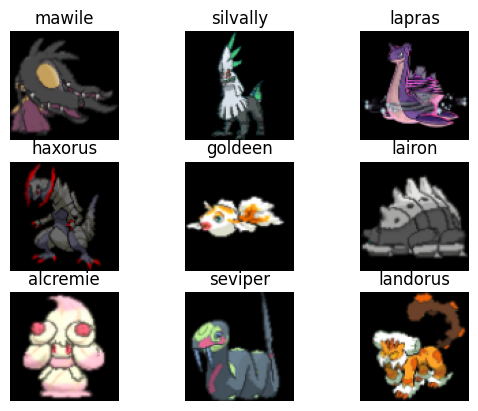

In [11]:
# print(trainPaths[15061])
for images, labels in trainDS.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy()*255).astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")
    plt.show()

### Define Model

In [12]:
counter = 0
for useBatchNorms in USE_BATCH_NORMS:
    for numConvLayers in NUM_LAYERS_CONV:
        for convNodes in NUM_NODES_IN_CONV:
            for convKernelSize in CONV_KERNEL_SIZE:
                for regIndex in range(0, len(REGULARIZER_LEARNING_RATE)):
                    for dropIndex in range(0, len(DROPOUT_RATE)):
                        counter += 1
                        
                        local_useReg = False
                        if regIndex is not None and regIndex != 0:
                            local_useReg = True
                            
                        #check if using dropout
                        local_useDropout = False #use dropout on layers other than hidden layer 
                        local_useDropout_hidden = False #use dropout on hidden layers
                        if DROPOUT_RATE[dropIndex] is not None and DROPOUT_RATE[dropIndex] != 0:
                            local_useDropout = True
                        if DROPOUT_RATE_HIDDEN[dropIndex] is not None and DROPOUT_RATE_HIDDEN[dropIndex] != 0:
                            local_useDropout_hidden = True

                        #create necessary log directories
                        local_usingAnyDropout = False
                        if local_useDropout is True or local_useDropout_hidden is True:
                            local_usingAnyDropout = True

                        local_container_dir = os.path.join(SESSION_LOG_DIR, f"{counter}.cl{numConvLayers}.cn{convNodes}.ckern{convKernelSize}.bnorm{useBatchNorms}.drop{local_usingAnyDropout}.reg{local_useReg}")
                        local_tensorlogs_dir = os.path.join(local_container_dir, 'fit/')
                        local_save_dir = os.path.join(local_container_dir, 'saves/')
                        local_checkpoint_dir = os.path.join(local_save_dir, 'checkpoints/')
                        local_finalsave_dir = os.path.join(local_save_dir, 'final/')

                        if os.path.isdir(local_container_dir) is False: 
                            os.mkdir(local_container_dir)
                        if os.path.isdir(local_tensorlogs_dir) is False: 
                            os.mkdir(local_tensorlogs_dir)
                        if os.path.isdir(local_save_dir) is False:
                            os.mkdir(local_save_dir)
                        if os.path.isdir(local_checkpoint_dir) is False:
                            os.mkdir(local_checkpoint_dir)
                        if os.path.isdir(local_finalsave_dir) is False: 
                            os.mkdir(local_finalsave_dir)

                        #write summary to file 
                        infoFile = os.path.join(local_container_dir, "into.txt")
                        with open(infoFile, 'w') as file: 
                            file.write(f"Number of convolution layers: {numConvLayers} \r")
                            file.write(f"Number of nodes per convolution layer: {convNodes} \r")
                            file.write(f"Input size expected: {IMAGE_WIDTH}, {IMAGE_HEIGHT}\r")
                            file.write(f"Epochs: {NUM_EPOCHS}\r")
                            file.write(f"Regularizers in use? {local_useReg}\r")
                            file.write(f"Regularizer learning rate: {REGULARIZER_LEARNING_RATE[regIndex]}\r")
                            file.write(f"Conv kernel size: {convKernelSize}\r")
                            file.write(f"Use Batch Normalization: {useBatchNorms}\r")
                            file.write(f"Use Dropout: {local_useDropout}\r")
                            file.write(f"Use Dropout on hidden: {local_useDropout_hidden}\r")
                            if local_useDropout: 
                                file.write(f"Dropout rate nonhidden: {DROPOUT_RATE[dropIndex]}\r")
                            if local_useDropout_hidden:
                                file.write(f"Dropout rate nonhidden: {DROPOUT_RATE_HIDDEN[dropIndex]}\r")
                            file.close()

                        #cleanup from last round 
                        tf.keras.backend.clear_session()

                        #define the model 
                        model = tf.keras.models.Sequential()
                        for i in range(numConvLayers):
                            if local_useReg is True:
                                model.add(tf.keras.layers.Conv2D(int(convNodes),
                                                                    convKernelSize,
                                                                    activation='relu',
                                                                    kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)))
                            else:
                                model.add(tf.keras.layers.Conv2D(int(convNodes), convKernelSize, activation='relu'))

                            if useBatchNorms is True:
                                model.add(tf.keras.layers.BatchNormalization())

                            #add additional properties to conv layers
                            model.add(tf.keras.layers.MaxPool2D((2,2)))
                            if useBatchNorms is True:
                                model.add(tf.keras.layers.BatchNormalization())
                            if local_useDropout:
                                model.add(tf.keras.layers.Dropout(DROPOUT_RATE[dropIndex]))

                        #flatten out 
                        model.add(tf.keras.layers.Flatten())
                        model.add(tf.keras.layers.Dense(512, activation='relu'))

                        if useBatchNorms is True: 
                            model.add(tf.keras.layers.BatchNormalization())
                        if local_useDropout_hidden is True:
                            model.add(tf.keras.layers.Dropout(DROPOUT_RATE_HIDDEN[dropIndex]))

                        model.add(tf.keras.layers.Dense(len(classNames), activation='softmax'))

                        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                optimizer=RMSprop(learning_rate=1e-4),
                                metrics=['accuracy'])

                        #create callbacks as necessary
                        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=local_checkpoint_dir, 
                                                                                save_weights_only=True, 
                                                                                verbose=1)
                        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=local_tensorlogs_dir,                        
                                                                            histogram_freq=1, 
                                                                            write_graph=True, 
                                                                            write_images=False, 
                                                                            embeddings_freq=1, 
                                                                            profile_batch='1,5')

                        time_stopping_callback = None
                        history = None
                        try:
                            if (trainTimeLimit != 0):
                                #shorten the time limit to allow for post training data processing
                                trainTimeLimit = trainTimeLimit - (60*5) 
                                time_stopping_callback = tfa.callbacks.TimeStopping(seconds=trainTimeLimit, verbose=1)
                                history = model.fit(trainDS, 
                                                    epochs=NUM_EPOCHS, 
                                                    validation_data=valDS,
                                                    callbacks=[tensorboard_callback, checkpoint_callback, time_stopping_callback])
                            else:
                                #no time limit callback
                                history = model.fit(trainDS, 
                                            epochs=NUM_EPOCHS, 
                                            validation_data=valDS,
                                            callbacks=[tensorboard_callback, checkpoint_callback])
                        except tf.errors.InvalidArgumentError as tferr:
                            print(tferr)
                            break


                        #save model and record completion in info file
                        model.save(local_finalsave_dir)
                        with open(infoFile, 'a') as file: 
                            file.write('Training Complete')
                            file.close()


Epoch 1/7
   2424/Unknown - 846s 346ms/step - loss: 4.0834 - accuracy: 0.3208
Epoch 00001: saving model to ../Logs/ubuntuLocal/20220427-194141/1.cl4.cn128.ckern(3, 3).bnormTrue.dropTrue.regFalse/saves/checkpoints/
2424/2424 [==============================] - 865s 354ms/step - loss: 4.0834 - accuracy: 0.3208 - val_loss: 650.4239 - val_accuracy: 0.0279
Epoch 2/7
2236/2424 [==========================>...] - ETA: 1:05 - loss: 1.6981 - accuracy: 0.7073

KeyboardInterrupt: 

#### Zip Logs For Download

In [ ]:
shutil.make_archive('Logs', 'zip', '../Logs')